In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import logging
from sklearn.isotonic import IsotonicRegression


%matplotlib inline

In [56]:
from causalml.dataset import make_uplift_classification_logistic
from causalml.dataset import make_uplift_classification

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
from pygam import LogisticGAM, s

In [59]:
from causalml.propensity import (
    ElasticNetPropensityModel,
    GradientBoostedPropensityModel,
    LogisticRegressionPropensityModel,
)
from causalml.metrics import roc_auc_score

In [60]:
from causalml.propensity import compute_propensity_score

# Copy code from tests/ to create data

In [7]:
RANDOM_SEED = 42
N_SAMPLE = 1000
ERROR_THRESHOLD = 0.5
NUM_FEATURES = 6

TREATMENT_COL = "treatment"
SCORE_COL = "score"
GROUP_COL = "group"
OUTCOME_COL = "outcome"

CONTROL_NAME = "control"
TREATMENT_NAMES = [CONTROL_NAME, "treatment1"]
CONVERSION = "conversion"
DELTA_UPLIFT_INCREASE_DICT = {
    "treatment1": 0.25,
}
N_UPLIFT_INCREASE_DICT = {"treatment1": 2}


In [8]:
np.random.seed(RANDOM_SEED)

## Create a more heterogeneous propensity score example

In [9]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of observations
n = 900 # must be divisible by three for this example
third = n // 3

X1 = uniform_vector = np.sort(np.random.uniform(low=0, high=10, size=n))

# Create three normally distributed arrays
first_third = np.random.normal(loc=0.1, scale=0.05, size=third)
second_third = np.random.normal(loc=0.5, scale=0.05, size=third)
third_third = np.random.normal(loc=0.9, scale=0.05, size=third)

# Combine the arrays
probabilities = np.concatenate([first_third, second_third, third_third])

# Clip values to ensure they're between 0 and 1
probabilities = np.clip(probabilities, 0, 1)

treatment_group_key = np.random.binomial(1, probabilities)

x_names = ['X1']

# Create the DataFrame
df = pd.DataFrame({
    'X1': X1,
    'treatment_group_key': treatment_group_key
})

# Display the first few rows and basic information about the DataFrame
print(df.head())
print("\nDataFrame Info:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Display the proportion of treatment group
print("\nProportion of treatment group (treatment_group_key = 1):")
print(df['treatment_group_key'].mean())

         X1  treatment_group_key
0  0.046320                    0
1  0.050616                    0
2  0.055221                    0
3  0.069521                    0
4  0.091971                    0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X1                   900 non-null    float64
 1   treatment_group_key  900 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 14.2 KB
None

Summary Statistics:
               X1  treatment_group_key
count  900.000000           900.000000
mean     4.923750             0.490000
std      2.936869             0.500178
min      0.046320             0.000000
25%      2.306189             0.000000
50%      5.018557             0.000000
75%      7.477720             1.000000
max      9.997177             1.000000

Proportion of treatment group (treatment_group_key =

In [10]:
x_names

['X1']

In [11]:
# split train, test for calibration
X_train, X_test, y_train, y_test = train_test_split(
    df[['X1']], df['treatment_group_key'], test_size=0.9, random_state=42
)

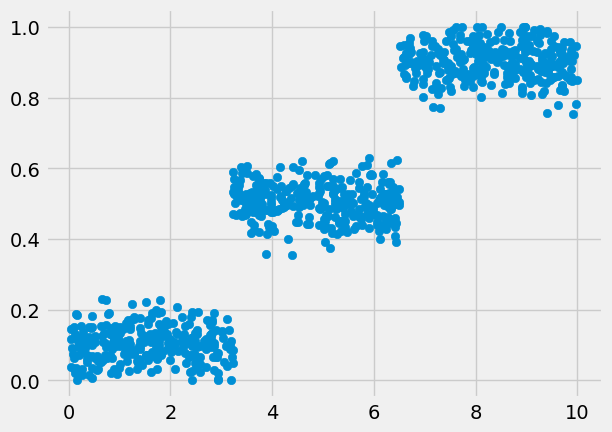

In [12]:
plt.scatter(X1, probabilities)

#  Fit propensity score models

## Logistic Regression (sci-kit learn)

In [13]:
pm_lr = LogisticRegression()

In [14]:
pm_lr.fit(X=X_train, y=y_train)

LogisticRegression()

In [15]:
ps_lr = pm_lr.predict_proba(X_test)[:, 1]

In [16]:
probs_test = probabilities[y_test.index.values] 

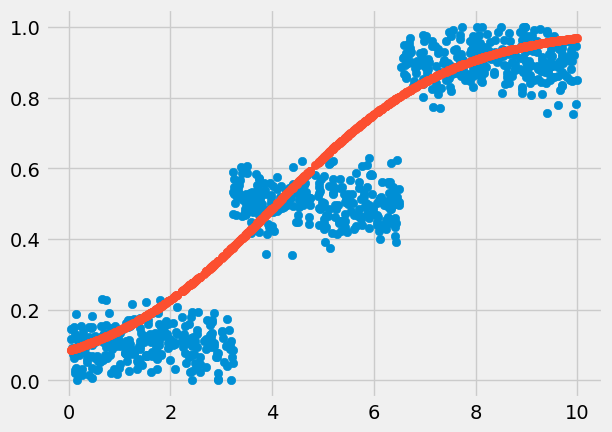

In [17]:
#plot the prediction vs the data
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_lr)

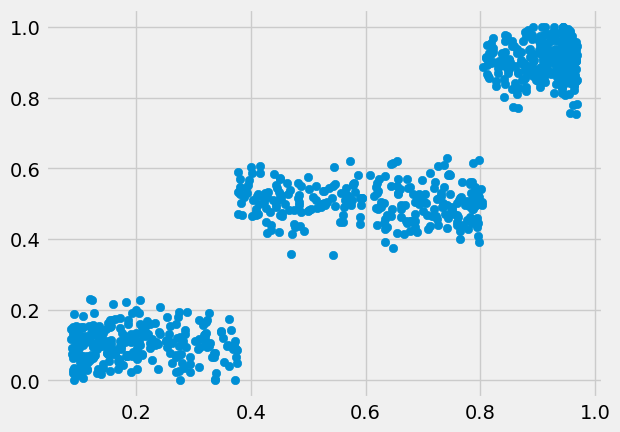

In [18]:
# calibration plot
plt.scatter(ps_lr, probs_test) # perfect calibration would be a straight line

## Logistic Regression (CausalML)

In [19]:
pm_lrcml = LogisticRegressionPropensityModel(random_state=RANDOM_SEED)
pm_lrcml.fit(X=X_train, y=y_train)
ps_lrcml = pm_lrcml.predict(X=X_test)

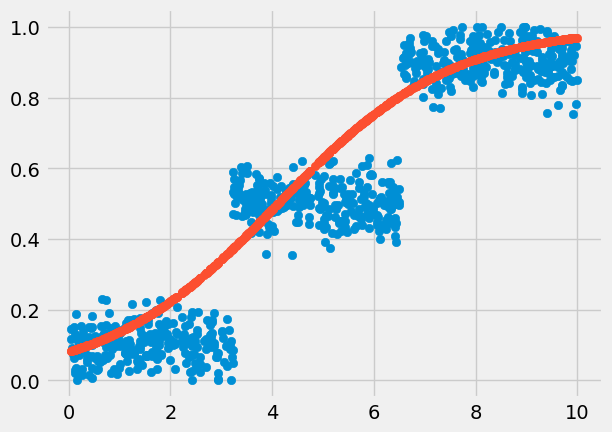

In [20]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_lrcml)

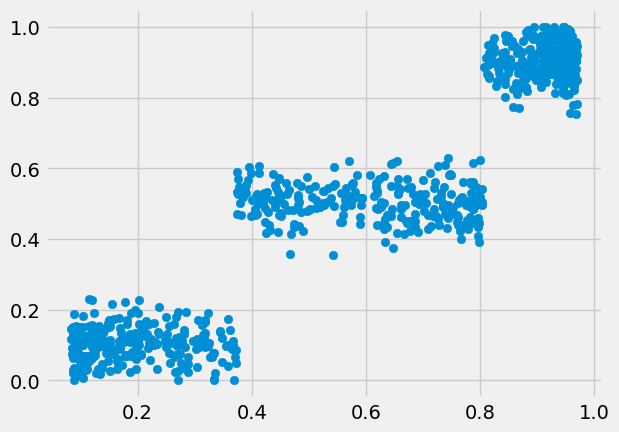

In [21]:
plt.scatter(ps_lrcml, probs_test)

## Elastic Net (CausalML)

In [22]:
pm_en = ElasticNetPropensityModel(random_state=RANDOM_SEED)
pm_en.fit(X_train, y_train)
ps_en = pm_en.predict(X_test)

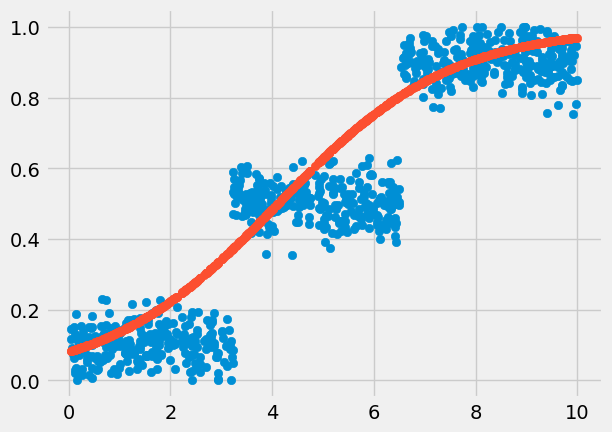

In [23]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_en)

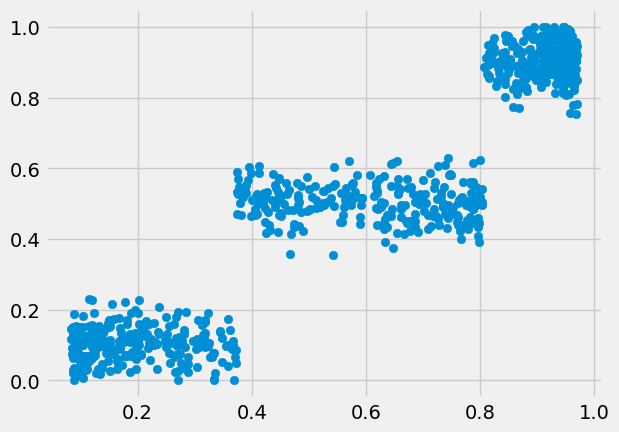

In [24]:
plt.scatter(ps_en, probs_test)

## Gradient Boosted Propensity Model

In [25]:
pm_gbm = GradientBoostedPropensityModel(random_state=RANDOM_SEED)
pm_gbm.fit(X_train, y_train)
ps_gbm = pm_gbm.predict(X_test)


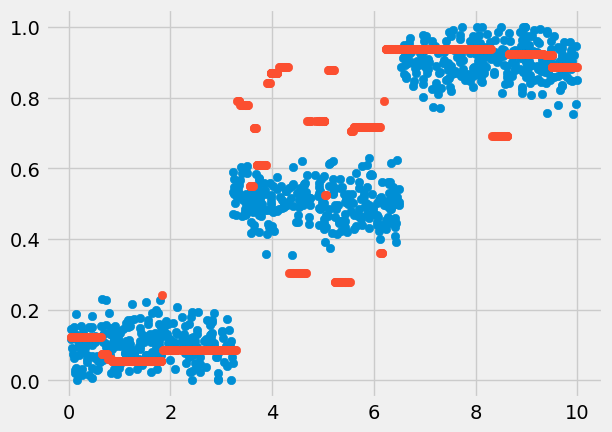

In [26]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_gbm)

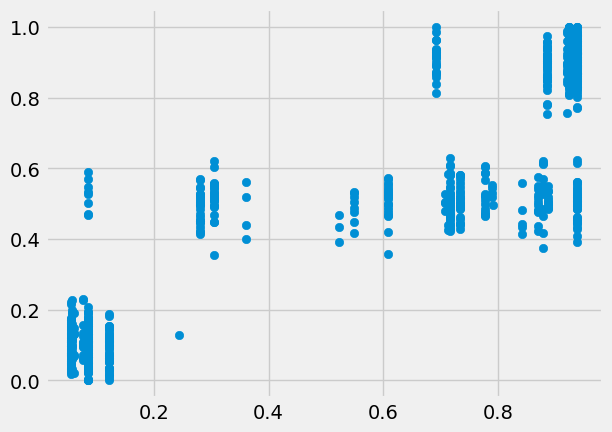

In [27]:
plt.scatter(ps_gbm, probs_test)

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
# NB model
clf = GaussianNB()

In [29]:
clf.fit(X_train, y_train)

GaussianNB()

In [30]:
ps_nb = clf.predict_proba(X_test)[:, 1]

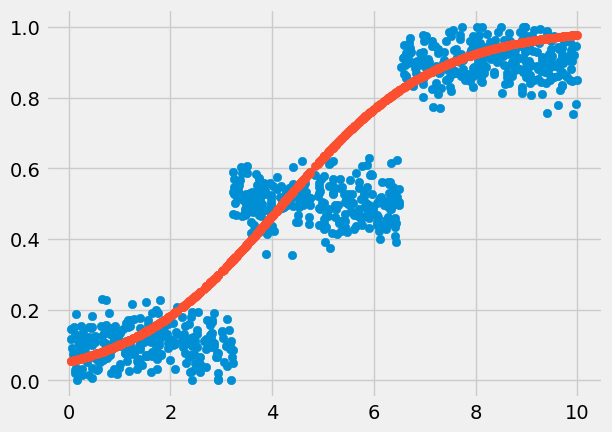

In [31]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_nb)

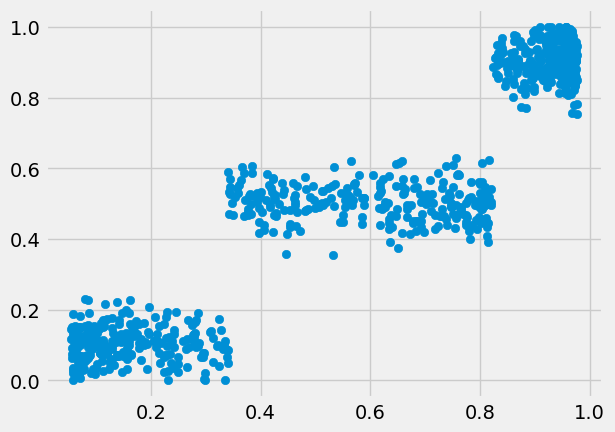

In [32]:
plt.scatter(ps_nb, probs_test)

# Looking at `compute_propensity_score`

##  Calculate the uncalibrated propensity scores 

This should just produce the NB scores

In [33]:
ps_cps_uc, psm_cps = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, calibrate_p=False)

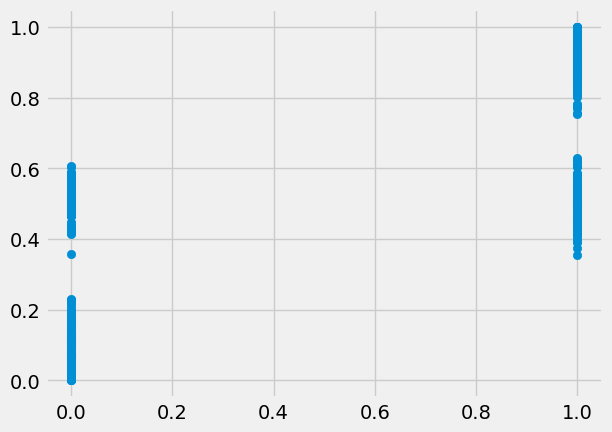

In [34]:
plt.scatter(ps_cps_uc, probs_test)

### this produces binomial values because currently compute_propensity_score doesn't use predict_proba

## Rewrite compute_propensity_score

In [61]:
def calibrate_iso(ps, treatment):
    """Calibrate propensity scores with IsotonicRegression.

    Ref: https://scikit-learn.org/stable/modules/isotonic.html

    Args:
        ps (numpy.array): a propensity score vector
        treatment (numpy.array): a binary treatment vector (0: control, 1: treated)

    Returns:
        (numpy.array): a calibrated propensity score vector
    """

    print("calibrate_iso")
    two_eps = 2.0 * np.finfo(float).eps
    pm_ir = IsotonicRegression(out_of_bounds="clip", y_min=two_eps, y_max=1.0 - two_eps)
    ps_ir = pm_ir.fit_transform(ps, treatment)

    return ps_ir

def calibrate_pygam(ps, treatment):
    """Calibrate propensity scores with logistic GAM.

    Ref: https://pygam.readthedocs.io/en/latest/api/logisticgam.html

    Args:
        ps (numpy.array): a propensity score vector
        treatment (numpy.array): a binary treatment vector (0: control, 1: treated)

    Returns:
        (numpy.array): a calibrated propensity score vector
    """

    print("calibrate_pygam")
    gam = LogisticGAM(s(0)).fit(ps, treatment)

    return gam.predict_proba(ps)


def compute_propensity_score(
    X, treatment, p_model=None, X_pred=None, treatment_pred=None, calibrate_p="iso"
):
    """Generate propensity score if user didn't provide

    Args:
        X (np.matrix): features for training
        treatment (np.array or pd.Series): a treatment vector for training
        p_model (propensity model object, optional):
            ElasticNetPropensityModel (default) / GradientBoostedPropensityModel
        X_pred (np.matrix, optional): features for prediction
        treatment_pred (np.array or pd.Series, optional): a treatment vector for prediciton
        calibrate_p (bool, optional): whether calibrate the propensity score

    Returns:
        (tuple)
            - p (numpy.ndarray): propensity score
            - p_model (PropensityModel): a trained PropensityModel object
    """

    print("using local compute_propensity_score")
    
    if treatment_pred is None:
        treatment_pred = treatment.copy()
    if p_model is None:
        p_model = ElasticNetPropensityModel()

    p_model.fit(X, treatment)

    if X_pred is None:
        try:
            p = p_model.predict_proba(X)[:, 1]
        except AttributeError:
            print("predict_proba not available, using predict instead")            
            p = p_model.predict(X)        
    else:
        try:
            p = p_model.predict_proba(X_pred)[:, 1]
        except AttributeError:
            print("predict_proba not available, using predict instead")            
            p = p_model.predict(X_pred)

    if calibrate_p == "iso":
        print("Isotonic calibrating propensity scores only.  Returning model=None.")
        p = calibrate_iso(p, treatment_pred)
        p_model = None
    elif calibrate_p == "pygam":
        print("pyGAM calibrating propensity scores only.  Returning model=None.")
        p = calibrate_pygam(p, treatment_pred)
        p_model = None

    # force the p values within the range
    eps = np.finfo(float).eps
    p = np.where(p < 0 + eps, 0 + eps * 1.001, p)
    p = np.where(p > 1 - eps, 1 - eps * 1.001, p)

    return p, p_model

## Recalculate the uncalibrated propensity scores

In [62]:
ps_cps_uc, psm_cps = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, calibrate_p=False)

using local compute_propensity_score


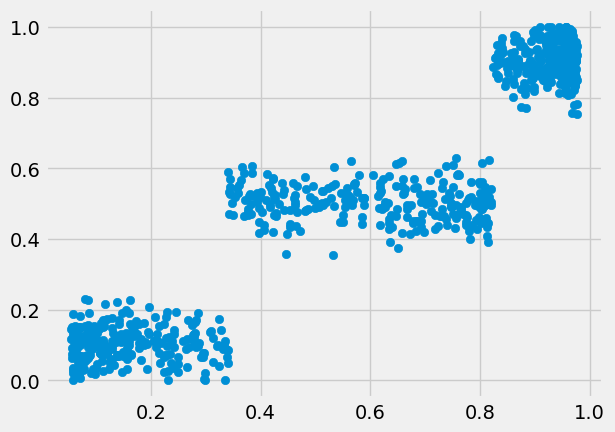

In [63]:
plt.scatter(ps_cps_uc, probs_test)

In [64]:
# this is as expected: the original NB propensity scores

# Compute the iso-calibrated propensity scores using `compute_propensity_score`

In [68]:
ps_cps_c, psm_cps = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, treatment_pred=y_test, calibrate_p="iso")


using local compute_propensity_score
Isotonic calibrating propensity scores only.  Returning model=None.
calibrate_iso


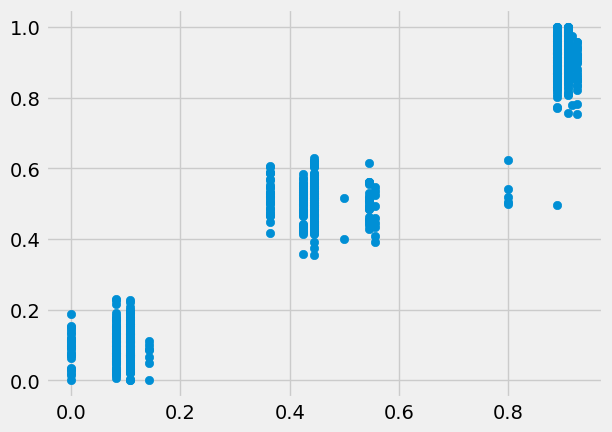

In [69]:
plt.scatter(ps_cps_c, probs_test)

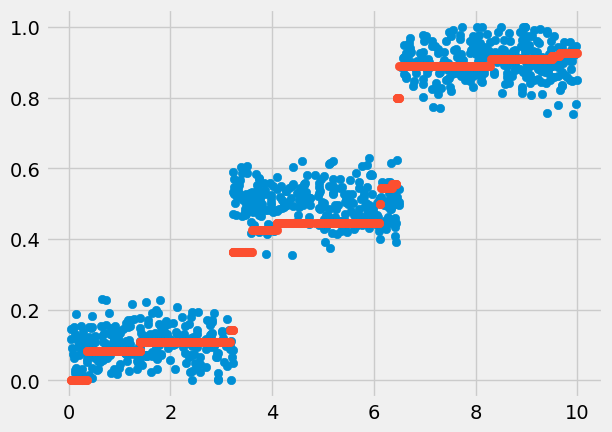

In [70]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_cps_c)

# Compute the pygam-calibrated propensity scores using `compute_propensity_score`

In [71]:
ps_cps_c, psm_cps = compute_propensity_score(X_train, y_train, p_model=clf, X_pred=X_test, treatment_pred=y_test, calibrate_p="pygam")

using local compute_propensity_score
pyGAM calibrating propensity scores only.  Returning model=None.
calibrate_pygam


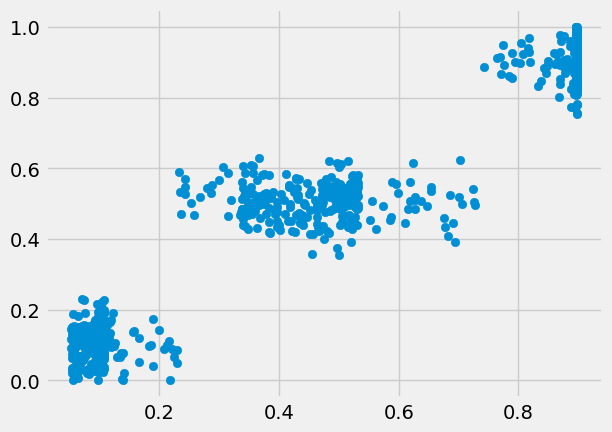

In [72]:
plt.scatter(ps_cps_c, probs_test)

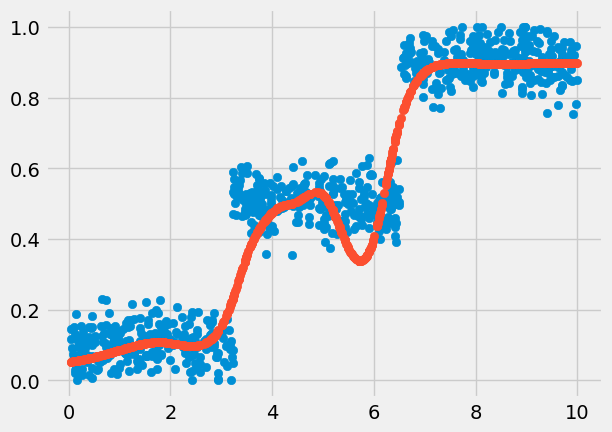

In [73]:
plt.scatter(X_test, probs_test)
plt.scatter(X_test, ps_cps_c)

# Scratch